In [7]:
import numpy as np
import torch
import meshplot as mp # useful for visualizing
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import primitive
import trimesh

In [8]:
# Loading a mesh and do uniformly samplings on the surface
mesh = trimesh.load_mesh('tube/tube.obj')  # ground truth: [width, height, thickness, dist, open_gap] = [20, 15, 1, 15, 10]

# Sample points uniformly from the surface of the mesh
points, _ = trimesh.sample.sample_surface_even(mesh, 1000)
points_numpy = np.array(points)
points_tensor = torch.tensor(points_numpy, dtype=torch.float32)

  0%|          | 0/2000 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

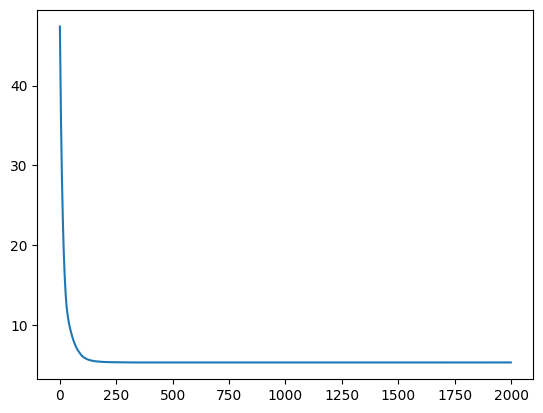

In [9]:
# diff. learning on a certain mesh input
import pytorch3d 
from pytorch3d.loss import chamfer_distance

opt_params = torch.randn(9)
opt_params[-3:] = torch.abs(opt_params[-3:])
opt_params.requires_grad = True

optimizer = torch.optim.Adam([opt_params], 0.1) # 0.1 is a good lr, 1 is not good

uv_coordinates = torch.rand((1000,2))
losses = []

points_tensor = points_tensor.view(1, -1, 3)


for _ in tqdm(range(2000)):
    optimizer.zero_grad()
    opt_points = primitive.tube(opt_params, uv_coordinates)
    opt_points = opt_points.view(1, -1, 3)
    
    loss = chamfer_distance(x = points_tensor, y = opt_points)
    loss = loss[0]
    
    loss.backward()
    optimizer.step()

    with torch.no_grad(): 
        opt_params[-3:] = torch.abs(opt_params[-3:])
        # if opt_params[-2] > 2*torch.pi:  # Is this is the error part??? seems to be true
        #     opt_params[-2] %= 2*torch.pi
        # if opt_params[-1] > opt_params[-3]:
        #     opt_params[-1] = opt_params[-3] / 2 

    losses.append(loss.detach().item())
plt.plot(losses)
plt.show  # the loss functions looks good but the results is totally wrong, no idea why ...... and parametrization looks good


In [10]:
# compare the original mesh with the optimized mesh
points_tensor = points_tensor.reshape(-1, 1, 3)
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(opt_points.detach().numpy(), shading={'point_size':2, 'point_color':'green'})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000208…

1

In [11]:
# check opt_params by plotting original mesh with the points cloud got by opt_params
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':2})

# opt_params is just the final parameters, so we have center, position, radius stored in opt_params
coordinates = torch.rand((1000, 2))
points = primitive.tube(opt_params, coordinates).detach().numpy()
plot.add_points(points, shading={'point_size':2, 'point_color':'green'})
# opt_params.detach().numpy()[-2] *= 180 / torch.pi
print(opt_params)  ## ground truth: [inner radius, thickness, length] = [5, 1, 20]  , center = [0 0 0], orientation = [0 0 1] (z-axis)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.000208…

tensor([ 0.0647, -0.1009, -0.0157, -0.8816, -0.4712, -0.0263,  4.6704,  3.3056,
        11.7007], requires_grad=True)


In [15]:
coordinates = torch.rand((1000, 2))
check = primitive.tube(torch.tensor([0,0,0, 0,0,1, 5, 1, 20], dtype=torch.float32), coordinates).detach().numpy()
mp.plot(check, return_plot=True, shading={'point_size':2})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-9.727478…